In [54]:

# # ⚙️ Step 1: Install PyTorch geometric dependencies
# !pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
# !pip install torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
# !pip install torch-geometric
# ✅ Full Graph Neural Network for Battery Voltage Modeling
# Using PyTorch Geometric (GCNConv)


import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import os
import zipfile

# ------------------ CONFIG ------------------
n_current_delays = 1
n_voltage_delays = 5
window_size = max(n_current_delays + 1, n_voltage_delays)
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

# ------------------ LOAD TRAINING DATA ------------------
data = pd.read_csv("/content/Combined_train_Data.csv")
current_raw = data['Current_A'].values
voltage_raw = data['Voltage_V'].values

# Normalize
scaler_I = MinMaxScaler().fit(current_raw.reshape(-1, 1))
scaler_V = MinMaxScaler().fit(voltage_raw.reshape(-1, 1))
current = scaler_I.transform(current_raw.reshape(-1, 1)).flatten()
voltage = scaler_V.transform(voltage_raw.reshape(-1, 1)).flatten()

# ------------------ INPUT CONSTRUCTION ------------------
X, Y = [], []
for t in range(window_size, len(current)):
    I_window = current[t - n_current_delays : t + 1][::-1]  # i(t), i(t-1)
    V_window = voltage[t - n_voltage_delays : t][::-1]      # v(t-1), ..., v(t-5)
    dI = np.diff(I_window, prepend=I_window[0])
    dV = np.diff(V_window, prepend=V_window[0])
    features = np.concatenate([I_window, V_window, dI, dV])
    features = np.concatenate([I_window, V_window])
    X.append(features)
    Y.append(voltage[t])

X = np.array(X)
Y = np.array(Y)

# ------------------ SPLIT TRAIN / VAL ------------------
N = len(X)
n_train = int(0.85 * N)
X_train, X_val = X[:n_train], X[n_train:]
Y_train, Y_val = Y[:n_train], Y[n_train:]

x_train = torch.tensor(X_train, dtype=torch.float).to(device)
y_train = torch.tensor(Y_train, dtype=torch.float).to(device)
x_val = torch.tensor(X_val, dtype=torch.float).to(device)
y_val = torch.tensor(Y_val, dtype=torch.float).to(device)

# Graph construction for train
src_train, tgt_train = [], []
for i in range(len(x_train)):
    for j in range(1, 4):
        if i - j >= 0:
            src_train.append(i)
            tgt_train.append(i - j)
edge_index_train = torch.tensor([src_train, tgt_train], dtype=torch.long)

graph_data_train = Data(x=x_train, edge_index=edge_index_train.to(device), y=y_train)

# Graph construction for val
src_val, tgt_val = [], []
for i in range(len(x_val)):
    for j in range(1, 4):
        if i - j >= 0:
            src_val.append(i)
            tgt_val.append(i - j)
edge_index_val = torch.tensor([src_val, tgt_val], dtype=torch.long)

graph_data_val = Data(x=x_val, edge_index=edge_index_val.to(device), y=y_val)

In [58]:
# ------------------ GCN MODEL ------------------
import torch.nn as nn
from torch_geometric.nn import GCNConv

class GCNVoltagePredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super().__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim // 2)
        self.lin = nn.Linear(hidden_dim // 2, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = self.lin(x)
        return x.view(-1)

model = GCNVoltagePredictor(input_dim=x.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()


In [59]:
x = torch.tensor(X, dtype=torch.float).to(device)
y = torch.tensor(Y, dtype=torch.float).to(device)  # ✅ ADD THIS!
y = y.to(device)
loss = criterion(out, y)  # both on device


In [60]:
# ------------------ TRAINING W/ EARLY STOPPING ------------------
epochs = 300
patience = 20
best_val_loss = float('inf')
counter = 0
best_model = None
model.train()

for epoch in range(epochs):
    optimizer.zero_grad()
    out_train = model(graph_data_train)
    loss = criterion(out_train, y_train)
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        out_val = model(graph_data_val)
        val_loss = criterion(out_val, y_val).item()

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = {k: v.clone() for k, v in model.state_dict().items()}
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"\U0001F6D1 Early stopping at epoch {epoch}")
            break

    if epoch % 50 == 0:
        print(f"Epoch {epoch}: Train Loss = {loss.item():.4f}, Val Loss = {val_loss:.4f}")
    model.train()

model.load_state_dict(best_model)

# ------------------ EVALUATION ------------------
model.eval()
with torch.no_grad():
    preds = model(graph_data_train).cpu().numpy()
    true_vals = y_train.cpu().numpy()

mse = mean_squared_error(true_vals, preds)
mae = mean_absolute_error(true_vals, preds)
rmse = np.sqrt(mse)
r2 = r2_score(true_vals, preds)
nrmse = rmse / (np.max(true_vals) - np.min(true_vals))

print("\n✨ Performance Metrics (Normalized):")
print(f"RMSE   : {rmse:.4f}")
print(f"MAE    : {mae:.4f}")
print(f"NRMSE  : {nrmse:.4f}")
print(f"R2     : {r2:.4f}")


Epoch 0: Train Loss = 0.7723, Val Loss = 0.7694
Epoch 50: Train Loss = 0.0134, Val Loss = 0.0105
Epoch 100: Train Loss = 0.0001, Val Loss = 0.0003
Epoch 150: Train Loss = 0.0001, Val Loss = 0.0001
Epoch 200: Train Loss = 0.0000, Val Loss = 0.0001
Epoch 250: Train Loss = 0.0000, Val Loss = 0.0000

✨ Performance Metrics (Normalized):
RMSE   : 0.0040
MAE    : 0.0024
NRMSE  : 0.0040
R2     : 0.9997


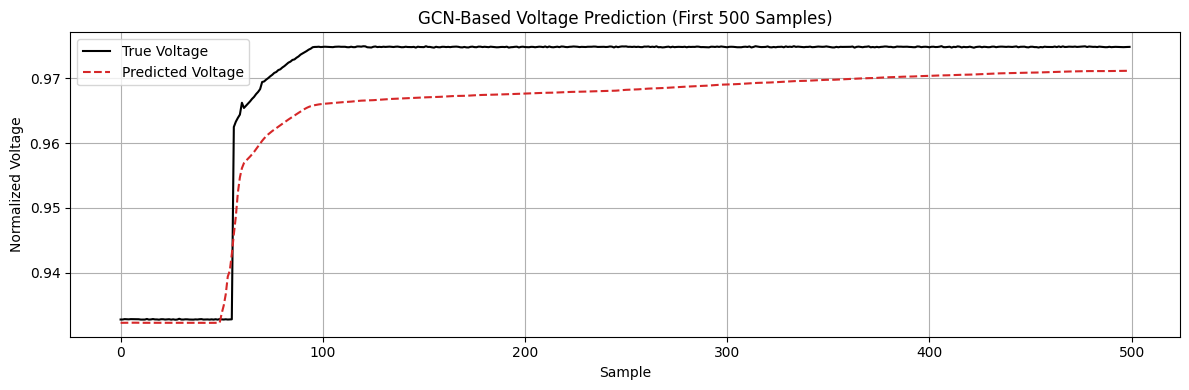

In [61]:
# ------------------ PLOT ------------------
plt.figure(figsize=(12, 4))
plt.plot(true_vals[:500], label="True Voltage", color='black')
plt.plot(preds[:500], label="Predicted Voltage", color='tab:red', linestyle='--')
plt.title("GCN-Based Voltage Prediction (First 500 Samples)")
plt.xlabel("Sample")
plt.ylabel("Normalized Voltage")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [70]:
model

GCNVoltagePredictor(
  (conv1): GCNConv(7, 64)
  (conv2): GCNConv(64, 32)
  (lin): Linear(in_features=32, out_features=1, bias=True)
)

In [67]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch_geometric.data import Data

# ------------------ Load Test Data ------------------
test_df = pd.read_excel("/content/Merged_test_Data.xlsx", engine="openpyxl")
current_test = test_df['Current_A'].values
voltage_test = test_df['Voltage_V'].values
time_test = test_df['Test_Time_s'].values

# ------------------ Normalize Using Training Scalers ------------------
# ✅ Reuse training-fitted scalers: scaler_I and scaler_V must come from training script
current_test_norm = scaler_I.transform(current_test.reshape(-1, 1)).flatten()
voltage_test_norm = scaler_V.transform(voltage_test.reshape(-1, 1)).flatten()

# ------------------ Closed-Loop GNN Prediction Function ------------------
def closed_loop_gnn_predict(model, current_norm, voltage_norm, scaler_V,
                            n_current_delays, n_voltage_delays, prediction_horizon, device):
    model.eval()
    preds_norm = []

    window_size = max(n_current_delays + 1, n_voltage_delays)

    # Initialize buffers with initial known values
    current_buffer = current_norm[:window_size].tolist()
    voltage_buffer = voltage_norm[:window_size].tolist()

    for step in range(prediction_horizon):
        # Get delayed input windows
        I_window = current_buffer[-(n_current_delays + 1):][::-1]  # e.g., I(t), I(t-1)
        V_window = voltage_buffer[-n_voltage_delays:][::-1]        # e.g., V(t-1), ..., V(t-5)

        # Final input vector (no derivatives)
        x_input = np.concatenate([I_window, V_window])

        # Create single-node graph
        x_tensor = torch.tensor(x_input, dtype=torch.float).unsqueeze(0).to(device)
        edge_index = torch.tensor([[0], [0]], dtype=torch.long).to(device)

        test_graph = Data(x=x_tensor, edge_index=edge_index)

        # Predict using GNN
        with torch.no_grad():
            y_pred = model(test_graph).item()
        preds_norm.append(y_pred)

        # Update voltage buffer with predicted value
        voltage_buffer.append(y_pred)

        # Update current buffer with next known current (or repeat last)
        if step + window_size < len(current_norm):
            current_buffer.append(current_norm[step + window_size])
        else:
            current_buffer.append(current_buffer[-1])  # hold last value

    # Denormalize predictions
    preds = scaler_V.inverse_transform(np.array(preds_norm).reshape(-1, 1)).flatten()
    return preds

# ------------------ Run Closed-loop Prediction ------------------
window_size = max(n_current_delays + 1, n_voltage_delays)
prediction_horizon = len(voltage_test_norm) - window_size

preds_denorm = closed_loop_gnn_predict(
    model=model,
    current_norm=current_test_norm,
    voltage_norm=voltage_test_norm,
    scaler_V=scaler_V,
    n_current_delays=n_current_delays,
    n_voltage_delays=n_voltage_delays,
    prediction_horizon=prediction_horizon,
    device=device
)


In [74]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import zipfile

def plot_voltage_current_denorm_metrics(
    true_voltage, preds, current_input, time_aligned,
    region_start, region_end, title_prefix="",
    metrics_excel_path="narx_metrics_log.xlsx",
    zip_name="narx_outputs.zip",
    download_zip=True):

    # --- Dynamic Region Mask ---
    mask = (time_aligned >= region_start) & (time_aligned <= region_end)
    time_dyn = time_aligned[mask]
    true_dyn = true_voltage[mask]
    pred_dyn = preds[mask]
    current_dyn = current_input[mask]
    time_rel = time_dyn - time_dyn[0] + 1  # Time starts from 1

    # --- Metrics ---
    rmse = np.sqrt(mean_squared_error(true_dyn, pred_dyn))
    mae = mean_absolute_error(true_dyn, pred_dyn)
    nrmse = rmse / (np.max(true_dyn) - np.min(true_dyn))
    r2 = r2_score(true_dyn, pred_dyn)

    print(f"\n📊 {title_prefix} Metrics ({region_start}-{region_end}s):")
    print(f"  RMSE   : {rmse:.4f} V")
    print(f"  MAE    : {mae:.4f} V")
    print(f"  NRMSE  : {nrmse:.4f}")
    print(f"  R²     : {r2:.4f}")

    # --- Save metrics to Excel ---
    metrics_row = {
        "Title": title_prefix,
        "Region Start (s)": region_start,
        "Region End (s)": region_end,
        "RMSE (V)": rmse,
        "MAE (V)": mae,
        "NRMSE": nrmse,
        "R2 Score": r2
    }
    if os.path.exists(metrics_excel_path):
        df_existing = pd.read_excel(metrics_excel_path)
        df_out = pd.concat([df_existing, pd.DataFrame([metrics_row])], ignore_index=True)
    else:
        df_out = pd.DataFrame([metrics_row])
    df_out.to_excel(metrics_excel_path, index=False)

    # --- Matplotlib Style ---
    plt.rcParams.update({
        "text.usetex": False,
        "font.family": "serif",
        "font.size": 11,
        "axes.labelsize": 11,
        "axes.titlesize": 12,
        "legend.fontsize": 10,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "axes.linewidth": 1.0
    })

    safe_title = title_prefix.replace(" ", "_").replace("-", "_")

    # --- Voltage Plot ---
    voltage_path = f"{safe_title}_voltage_{region_start}_{region_end}.pdf"
    fig, ax = plt.subplots(figsize=(6.5, 3.2))
    ax.plot(time_rel, true_dyn, label='True', color='black', linewidth=1.2)
    ax.plot(time_rel, pred_dyn, '--', label='Prediction', color='tab:red', linewidth=1.2)
    ax.set_title(title_prefix)
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Voltage [V]")
    ax.legend(loc='upper right', frameon=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(direction='in', length=5, width=1)
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
    plt.tight_layout()
    plt.savefig(voltage_path, dpi=300, bbox_inches='tight')
    plt.show()

    # --- Current Plot ---
    current_path = f"{safe_title}_current_{region_start}_{region_end}.pdf"
    fig, ax = plt.subplots(figsize=(6.5, 2.8))
    ax.plot(time_rel, current_dyn, color='tab:blue', label='Input Current', linewidth=1.2)
    ax.set_title(title_prefix)
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Current [A]")
    ax.legend(loc='upper right', frameon=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(direction='in', length=5, width=1)
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
    plt.tight_layout()
    plt.savefig(current_path, dpi=300, bbox_inches='tight')
    plt.show()

    # --- Zip all files together ---
    with zipfile.ZipFile(zip_name, 'w') as zipf:
        zipf.write(voltage_path)
        zipf.write(current_path)
        zipf.write(metrics_excel_path)

    print(f"\n🗜️  Created ZIP: {zip_name}")

    # --- Trigger download in Colab ---
    if download_zip:
        try:
            from google.colab import files
            files.download(zip_name)
        except:
            print("💡 Not running in Colab or download failed.")

    return zip_name


In [ ]:


start_time = 72500
end_time = 74000


plot_voltage_current_denorm_metrics(
    true_voltage=true_voltage,
    preds=preds,
    current_input=scaler_I.inverse_transform(current_test_norm[max_delay: max_delay + len(preds)].reshape(-1, 1)).flatten(),
    time_aligned=time_aligned,
    region_start=start_time,
    region_end=end_time,
    title_prefix="Transient Dynamics"
)





In [68]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# ------------------ Evaluate and Export ------------------
def plot_voltage_current_denorm_metrics(
    true_voltage, preds, current_input, time_aligned,
    region_start, region_end, title_prefix="",
    metrics_excel_path=None,
    zip_name=None,
    download_zip=False):

    # --- Compute Metrics (Denormalized) ---
    rmse = np.sqrt(mean_squared_error(true_voltage, preds))
    mae = mean_absolute_error(true_voltage, preds)
    nrmse = rmse / (np.max(true_voltage) - np.min(true_voltage))
    r2 = r2_score(true_voltage, preds)

    print(f"\n📊 {title_prefix} Metrics (Denormalized):")
    print(f"  RMSE   : {rmse:.4f} V")
    print(f"  MAE    : {mae:.4f} V")
    print(f"  NRMSE  : {nrmse:.4f}")
    print(f"  R²     : {r2:.4f}")

    # --- Dynamic Region Mask ---
    mask = (time_aligned >= region_start) & (time_aligned <= region_end)
    time_dyn = time_aligned[mask]
    true_dyn = true_voltage[mask]
    pred_dyn = preds[mask]
    current_dyn = current_input[mask]

    # --- Voltage Plot (Denormalized) ---
    plt.figure(figsize=(14, 5))
    plt.plot(time_dyn, true_dyn, label='True Voltage (V)', color='black')
    plt.plot(time_dyn, pred_dyn, '--', label='Predicted Voltage (V)', color='tab:red')
    plt.title(f"{title_prefix} - Voltage Dynamics [{region_start}-{region_end}s]")
    plt.xlabel("Time [s]")
    plt.ylabel("Voltage [V]")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    # --- Current Plot (Denormalized) ---
    plt.figure(figsize=(14, 4))
    plt.plot(time_dyn, current_dyn, color='tab:blue', label='Input Current (A)')
    plt.title(f"{title_prefix} - Input Current [{region_start}-{region_end}s]")
    plt.xlabel("Time [s]")
    plt.ylabel("Current [A]")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

def evaluate_and_export_gnn(model, x, y, current_raw, scaler_V, scaler_I, time_vector, title_prefix, region_start, region_end):
    model.eval()
    with torch.no_grad():
        preds_norm = model(graph_data_test).cpu().numpy()
        true_norm = y.cpu().numpy()

    preds = scaler_V.inverse_transform(preds_norm.reshape(-1, 1)).flatten()
    true_voltage = scaler_V.inverse_transform(true_norm.reshape(-1, 1)).flatten()
    current_input = scaler_I.inverse_transform(x[:, 0].cpu().numpy().reshape(-1, 1)).flatten()
    time_aligned = time_vector[-len(preds):]  # aligned with prediction horizon

    # Plotting and metric export (reuses shared function)
    return plot_voltage_current_denorm_metrics(
        true_voltage, preds, current_input, time_aligned,
        region_start, region_end, title_prefix,
        metrics_excel_path="gnn_metrics_log.xlsx",
        zip_name="gnn_outputs.zip",
        download_zip=True
    )


In [72]:
x_test.shape

torch.Size([82251, 14])

In [69]:
# ------------------ Call for Desired Regions ------------------
start_time = 72500
end_time = 74000

evaluate_and_export_gnn(
    model=model,
    x=x_test,
    y=y_test,
    current_raw=current_test,
    scaler_V=scaler_V,
    scaler_I=scaler_I,
    time_vector=time_test[window_size:],
    title_prefix="Transient Dynamics",
    region_start=start_time,
    region_end=end_time
)



RuntimeError: mat1 and mat2 shapes cannot be multiplied (82251x14 and 7x64)

In [ ]:
start_time = 62000
end_time = 66000

evaluate_and_export_gnn(
    model=model,
    x=x_test,
    y=y_test,
    current_raw=current_test,
    scaler_V=scaler_V,
    scaler_I=scaler_I,
    time_vector=time_test[window_size:],
    title_prefix="Steady State Dynamics",
    region_start=start_time,
    region_end=end_time
)

In [ ]:
# -------- Step 7: Denormalize & Plot --------
import numpy as np
predicted_voltage = np.array(predicted_voltage) * voltage_std + voltage_mean
true_voltage = voltage[pred_start:] * voltage_std + voltage_mean

plt.figure(figsize=(12, 5))
plt.plot(predicted_voltage, label="Predicted Voltage (Closed-loop)", linewidth=1)
plt.plot(true_voltage, label="Actual Voltage", linewidth=1, alpha=0.7)
plt.title(f"GNN Battery Voltage Prediction (Closed-loop) | Window = {window_size}")
plt.xlabel("Time Step")
plt.ylabel("Voltage (V)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# -------- Step 8: NRMSE Evaluation --------
nrmse = np.sqrt(np.mean((predicted_voltage - true_voltage) ** 2)) / (np.max(true_voltage) - np.min(true_voltage))
print(f"\nClosed-loop NRMSE: {nrmse:.4f}")

In [ ]:
# NEW CODE

In [4]:

# ⚙️ Step 1: Install PyTorch geometric dependencies
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
!pip install torch-geometric

import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv


Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.0/494.0 kB 20.8 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 71.7 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_sparse/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ------------------ Load & Normalize Data ------------------
data = pd.read_csv("/content/Combined_train_Data.csv")
voltage = data['Voltage_V'].values
current = data['Current_A'].values

# Downsample or preprocess if needed here

scaler_I = MinMaxScaler().fit(current.reshape(-1, 1))
scaler_V = MinMaxScaler().fit(voltage.reshape(-1, 1))
current_norm = scaler_I.transform(current.reshape(-1, 1)).flatten()
voltage_norm = scaler_V.transform(voltage.reshape(-1, 1)).flatten()

# ------------------ Build NARX-style Input ------------------
n_current_delays = 2
n_voltage_delays = 50

def build_narx_input(current, voltage, n_current_delays, n_voltage_delays):
    X, y = [], []
    max_delay = max(n_current_delays, n_voltage_delays)
    for t in range(max_delay, len(current)):
        I_window = current[t - n_current_delays : t + 1][::-1]
        V_window = voltage[t - n_voltage_delays : t][::-1]
        x_input = np.concatenate([I_window, V_window])
        X.append(x_input)
        y.append(voltage[t])
    return np.array(X), np.array(y)

X, y = build_narx_input(current_norm, voltage_norm, n_current_delays, n_voltage_delays)

# ------------------ Build Graph Data ------------------
def build_graph(X, y):
    edge_index = []
    for i in range(len(X)):
        for j in range(X.shape[1]):
            if j < len(X):
                edge_index.append([i, j])
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    x = torch.tensor(X, dtype=torch.float)
    y = torch.tensor(y, dtype=torch.float).unsqueeze(1)
    return Data(x=x, edge_index=edge_index, y=y)

data_gnn = build_graph(X, y)

# ------------------ Define GCN Model ------------------
class GCNNet(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim // 2)
        self.fc = nn.Linear(hidden_dim // 2, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.silu(self.conv1(x, edge_index))
        x = F.silu(self.conv2(x, edge_index))
        x = self.fc(x)
        return torch.clamp(x, 0.0, 1.0)

# ------------------ Train GCN ------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GCNNet(input_dim=X.shape[1], hidden_dim=64).to(device)
data_gnn = data_gnn.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
epochs = 500

model.train()
for epoch in range(epochs):
    optimizer.zero_grad()
    out = model(data_gnn)
    loss = criterion(out, data_gnn.y)
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

# ------------------ Evaluation ------------------
model.eval()
with torch.no_grad():
    y_pred = model(data_gnn).cpu().numpy().flatten()
    y_true = data_gnn.y.cpu().numpy().flatten()

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
nrmse = rmse / (np.max(y_true) - np.min(y_true))

print("GNN Model Performance:")
print(f"  RMSE  : {rmse:.4f}")
print(f"  MAE   : {mae:.4f}")
print(f"  R2    : {r2:.4f}")
print(f"  NRMSE : {nrmse:.4f}")

# ------------------ Plot ------------------
plt.figure(figsize=(14, 5))
plt.plot(y_true[:500], label='True Voltage')
plt.plot(y_pred[:500], '--', label='Predicted Voltage')
plt.title("GNN Prediction vs True (First 500 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Normalized Voltage")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


OutOfMemoryError: CUDA out of memory. Tried to allocate 17.22 GiB. GPU 0 has a total capacity of 14.74 GiB of which 10.61 GiB is free. Process 6920 has 4.13 GiB memory in use. Of the allocated memory 3.00 GiB is allocated by PyTorch, and 1.01 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)